In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
%matplotlib inline

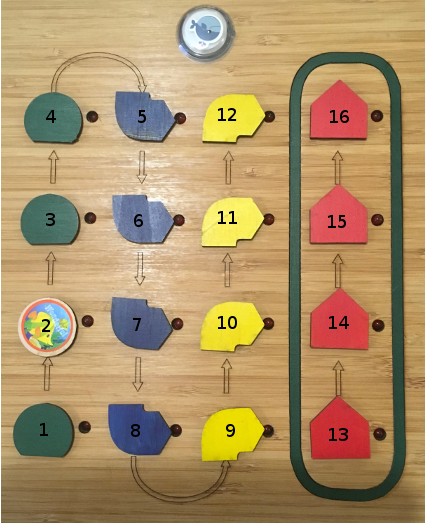

In [4]:
from sklearn.base import TransformerMixin
from itertools import combinations
class AddFeatureCombinationsTransform(TransformerMixin):
    def __init__(self,columns,func,keep_columns=False):
        self.columns = columns
        self.func = func
        self.keep = keep_columns
    
    def transform(self, X, *_):
        result = X.copy()
        for (col1,col2) in combinations(self.columns,2):
            result[self.func.__name__+"_"+col1+"_"+col2] = self.func(result[col1],result[col2])
        if not self.keep:
            result.drop(self.columns,axis=1,inplace=True)
        return result
        
    def fit(self, *_):
        return self

def cross_product_features(df, categorical, features):
    """
    Arguaments:
        df: a DataFrame
        categorical: the categorical feature representing which group a row belongs to.
        features: the features we wish to cross with the categorical feature.
    """
    dummied = pd.get_dummies(df,columns=[categorical],prefix='cat')
    dumies = dummied[[c for c in dummied.columns if c.startswith('cat_')]]
    result = [dummied]
    for col in features:
        cross = dumies.multiply(df[col],axis=0)
        cross.columns = [c+"_"+col for c in cross.columns]
        result.append(cross)
        
    return pd.concat(result,axis=1)

class IndividualizedModel(object):
    """
    Fit a seperate instance of the model for each value of group_column. 
    Assumes that X is a DataFrame and y a series with the same index.
    """
    def __init__(self,model,group_column,**kwargs):
        self.model = model
        self.group = group_column
        self.models = {}
        self.kwargs = kwargs
        
    def fit(self,X,y):
        for name, group in X.groupby(self.group):
            self.models[name] = self.model(**self.kwargs)
            self.models[name].fit(group,y.iloc[group.index])
        return self
        
    def predict(self,X):
        result = []
        for name, group in X.groupby(self.group):
            y_pred = pd.Series(self.models[name].predict(group),group.index)
            result.append(y_pred)
        result = pd.concat(result)
        return result.sort_index() # should modify to be align index

## Exploring colors

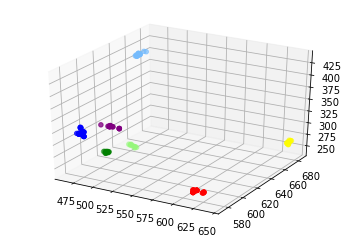

In [5]:
# figure out why the blue (and occasionally green) have low values in early rows of the shuffle.
# does this happen if all lights flash regardless of off values?
df = pd.read_csv("data/colors_201804012109.csv",header=None,names = ["tile","off","red","green","blue","color"])
df = df[df['blue'] > 150]
df.loc[df['color']=='light green','color'] = 'xkcd:light green'
df.loc[df['color']=='light blue','color'] = 'xkcd:sky blue'
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['red'],df['green'],df['blue'],color=df['color'])
plt.show()

In [6]:
# compute distances between colors
t = pd.merge(df,df,how='outer',suffixes=('_a','_b'),on='tile')
t = t.loc[t['color_a']>t['color_b']]
t['dist'] = np.sqrt(np.power(t['red_a']-t['red_b'],2)+
                    np.power(t['green_a']-t['green_b'],2)+np.power(t['blue_a']-t['blue_b'],2))
colors = list(df['color'].unique())
t.groupby(['color_a','color_b'])['dist'].agg(['mean','min']).reset_index().sort_values('min')

,color_a,color_b,mean,min
7,xkcd:light green,green,24.795487,19.287302
1,purple,blue,35.748420,20.223748
0,green,blue,68.746641,59.093147
6,xkcd:light green,blue,80.628055,68.293484
8,xkcd:light green,purple,87.112341,74.739548
2,purple,green,83.914008,75.650512
18,yellow,red,106.106144,99.005050
12,xkcd:sky blue,purple,114.846092,109.274883
10,xkcd:sky blue,blue,131.538457,118.055072
5,red,purple,144.452391,133.427883


## Modelling

In [128]:
df = pd.read_csv("data/data_201804072112.csv",header=None,names = ["tile","off","red","green","blue","color"])

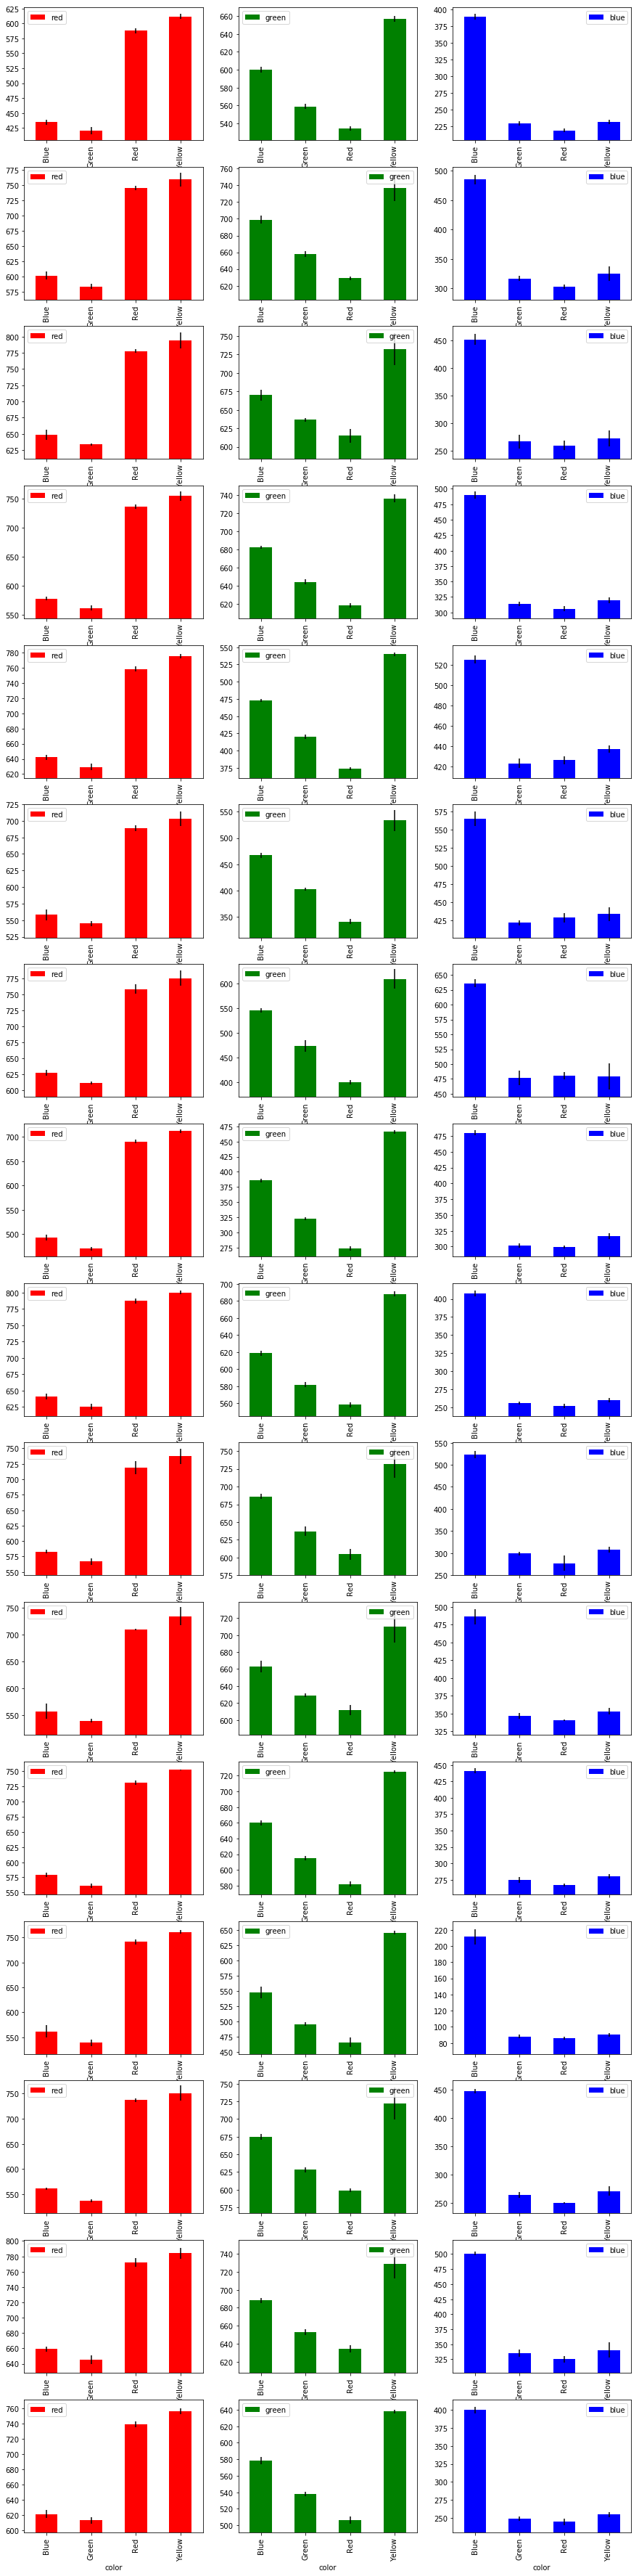

In [8]:
valid = df[df['off']<20]
mu = valid.groupby(['tile','color']).median()
std = 3*valid.groupby(['tile','color']).std()
fig,ax = plt.subplots(16,3,figsize = (15,16*4))
for i in range(16):
    for j,color in enumerate(['red','green','blue']):
        m = mu.loc[i]
        s = std.loc[i]
        m.plot.bar(y=color,color=color,yerr = s[color],ax = ax[i][j])
        low,high = m.agg(['min','max'])[color]
        smax = s.max()[color]
        ax[i][j].set_ylim(low-smax-10,high+smax+10)
        

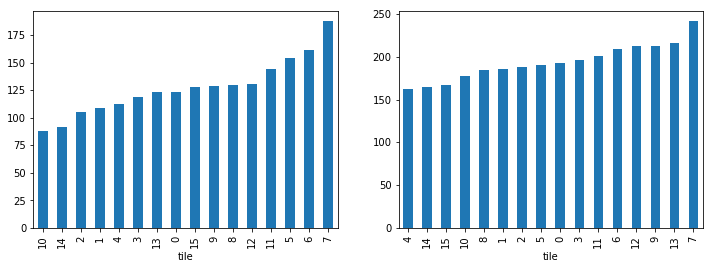

In [130]:
# what does the distribution of distance look like by tile
fig,ax = plt.subplots(1,2,figsize=(12,4))
non_match.groupby('tile')['distance'].mean().sort_values().plot(kind='bar',ax=ax[1])
non_match.groupby('tile')['distance'].min().sort_values().plot(kind='bar',ax=ax[0])

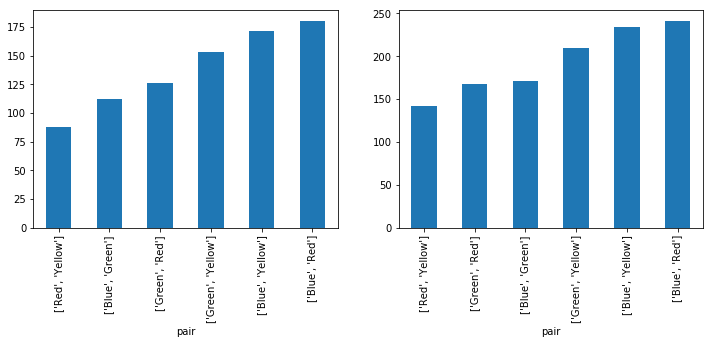

In [140]:
# implement centroid algorithm 
centers = valid.groupby(['tile','color']).median().reset_index(level=1)
vc = valid.set_index(['tile']).join(centers,rsuffix='_c')

def distance(r):
    colors = ['red','green','blue']
    distance = np.sqrt(np.asarray([(r[color] - r[color+"_c"])**2 for color in colors]).sum())
    return distance
    
vc['distance'] = vc.apply(distance,axis=1) 

non_match = vc[vc['color']!=vc['color_c']].reset_index()
non_match['pair'] = list(str(sorted(tp)) for tp in zip(non_match['color'],non_match['color_c']))
fig,ax = plt.subplots(1,2,figsize=(12,4))
non_match.groupby('pair')['distance'].min().sort_values().plot(kind='bar',ax=ax[0])
non_match.groupby('pair')['distance'].mean().sort_values().plot(kind='bar',ax=ax[1])

In [186]:
def array_as_c_definition(array,varname):
    assert array.dtype == int
    shape = "".join(['[{}]'.format(s) for s in array.shape])
    data = np.array2string(array,separator=",").replace('[','{').replace(']','}').replace('\n','').replace(' ','')
    result = 'int {0}{1}={2};'.format(varname,shape,data)
    return result
    
    

In [ ]:
char instruction(int rawInput){
  if (rawInput < 0){
    return NOOP;
  } if (rawInput == 0) {
    return LEFT; 
  } if (rawInput == 2){
    return FUNCTION;
  } if (rawInput == 1) {
    return FORWARD;
  }
  return RIGHT;
}

In [202]:
color2char = {
    'Blue':'L',
    'Red':'F',
    'Yellow':'R',
    'Green':'C'
}
colors = centers['color'].unique()

In [208]:
def color2char_func_str(colors,color2char):
    result = 'char instruction(int indx){\n'
    colors = sorted(colors) # sort them as we do in producing the array so the ording is consistent
    for indx,color in enumerate(colors):
        char = color2char[color]
        if len(char) != 1:
            raise ValueError('Each color should map to a single character')
        if char == 'N':
            raise ValueError('N is reserved to indicate NOOP')
        result += "   if (indx == {}){{return '{}';}}\n".format(indx,char)
    result += "   return 'N';\n}"
    return result

print color2char_func_str(colors,color2char)
        

char instruction(int indx){
   if (indx == 0){return 'L';}
   if (indx == 1){return 'C';}
   if (indx == 2){return 'F';}
   if (indx == 3){return 'R';}
   return 'N';
}


In [187]:
data = centers.round().reset_index().sort_values(['tile','color'])[['red','green','blue']].values.reshape((16,4,3)).astype(int)
print array_as_c_definition(data,'centers')

int centers[16][4][3]={{{434,600,389},{420,559,230},{588,534,219},{612,657,232}},{{602,699,485},{584,658,317},{745,629,303},{759,737,325}},{{648,670,451},{634,636,266},{778,615,260},{794,732,272}},{{578,682,490},{562,644,314},{736,618,306},{754,736,320}},{{642,472,525},{630,420,423},{758,374,426},{775,540,437}},{{558,467,565},{545,403,422},{689,341,429},{704,534,434}},{{628,546,636},{612,474,477},{759,401,480},{776,609,479}},{{494,386,480},{470,323,302},{690,274,299},{712,466,317}},{{641,618,408},{626,582,256},{787,558,252},{800,688,260}},{{583,686,523},{567,637,299},{719,605,277},{737,732,308}},{{558,663,486},{540,629,347},{709,612,340},{734,710,353}},{{579,660,441},{561,615,275},{731,582,267},{752,725,280}},{{562,548,212},{539,496,88},{742,466,86},{761,646,90}},{{561,675,448},{537,628,264},{737,599,250},{751,722,271}},{{659,688,501},{646,653,335},{772,634,325},{784,729,340}},{{622,578,400},{613,538,249},{739,506,245},{756,638,255}}};


In [9]:
# Goal. Find a simple and robust classifer that I can implement on Arduino. 
# Could test accuracy as a function of the error level. (Simulate data gaussian with mean and increasing std.)
# In many cases the ratio of two colors is a good predictor. 
#What kind of boundaries do you get under logistic regression, LDA or (linear) SVM?

In [52]:
num_errors = 5
samples = 200
mu = valid.groupby(['tile','color']).agg(['mean','std']).reset_index()
red = np.random.normal(mu[('red','mean')],num_errors*mu[('red','std')],size = (samples,len(mu))).ravel()
green = np.random.normal(mu[('green','mean')],num_errors*mu[('green','std')],size = (samples,len(mu))).ravel()
blue = np.random.normal(mu[('blue','mean')],num_errors*mu[('blue','std')],size = (samples,len(mu))).ravel()
simulated = pd.DataFrame({
    'red':red,'green':green,'blue':blue,'tile':np.tile(mu['tile'],samples),'color':np.tile(mu['color'],samples)})
train_indx = int(samples*2/3.0)*len(mu)
train = simulated.iloc[0:train_indx]
test = simulated.iloc[train_indx:]

In [53]:
X_train,X_test = train[['red','green','blue','tile']],test[['red','green','blue','tile']]
y_train, y_test = train['color'],test['color']


In [54]:
from sklearn.svm import SVC
model = SVC()
y_pred = model.fit(X_train,y_train).predict(X_test)
confusion_matrix(y_test,y_pred)

array([[ 683,    0,    0,  389],
       [   0,  754,    0,  318],
       [   0,    0,  730,  342],
       [   0,    0,    0, 1072]])

In [55]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
y_pred = model.fit(X_train,y_train).predict(X_test)
confusion_matrix(y_test,y_pred)

array([[1071,    1,    0,    0],
       [   0, 1071,    1,    0],
       [   0,    0, 1072,    0],
       [   0,    0,    4, 1068]])

In [56]:
model = LogisticRegression()
y_pred = model.fit(X_train,y_train).predict(X_test)
confusion_matrix(y_test,y_pred)

array([[997,  67,   0,   8],
       [208, 795,  67,   2],
       [  0,  64, 690, 318],
       [  2,  67, 243, 760]])

In [57]:
from sklearn.svm import SVC
model = IndividualizedModel(SVC,'tile',kernel='linear')
y_pred = model.fit(X_train,y_train).predict(X_test)
confusion_matrix(y_test,y_pred)

array([[1072,    0,    0,    0],
       [   0, 1072,    0,    0],
       [   0,    0, 1072,    0],
       [   0,    0,    3, 1069]])

In [59]:
model = IndividualizedModel(LogisticRegression,'tile')
y_pred = model.fit(X_train,y_train).predict(X_test)
confusion_matrix(y_test,y_pred)

array([[1072,    0,    0,    0],
       [   0, 1072,    0,    0],
       [   0,    0, 1072,    0],
       [   0,    1,    8, 1063]])

In [60]:
train_d = cross_product_features(train,'tile',['red','green','blue'])
test_d = cross_product_features(test,'tile',['red','green','blue'])
X_train,X_test = train_d[[c for c in train_d.columns if c!='color']],test_d[[c for c in test_d.columns if c!='color']]
y_train,y_test = train_d['color'],test_d['color']
model = LogisticRegression()
y_pred = model.fit(X_train,y_train).predict(X_test)
confusion_matrix(y_test, y_pred) # get 100% accuary on the training data. 

array([[1072,    0,    0,    0],
       [   0, 1069,    0,    3],
       [   0,    0, 1069,    3],
       [   0,   10,    9, 1053]])

In [35]:
from sklearn.pipeline import Pipeline
def ratio(a,b):
    return a/b
rt = AddFeatureCombinationsTransform(['red','green','blue'],ratio)
model = Pipeline([('take_ratios', rt), ('classify', LogisticRegression())])
y_pred = model.fit(X_train,y_train).predict(X_test)
confusion_matrix(y_test,y_pred)

array([[544,   0,   0,   0],
       [  0, 544,   0,   0],
       [  0,   0, 544,   0],
       [  0,   0,   0, 544]])

In [ ]:
# blue and green are close to being mixed up. 

In [475]:
color2val = {'Red':0,'Green':1,'Blue':2,'Yellow':3}
def map_vals(array,dictionary):
    return np.asarray([dictionary[i] for i in array])

blue = 240

# plot decision surface
features = ['red','green']
k = 500
f1_min,f2_min,f1_max,f2_max = X[features].agg(['min','max']).values.ravel()
xx,yy = np.meshgrid(np.linspace(f1_min-10,f1_max+10,k),np.linspace(f2_min-10,f2_max+10,k))
X2 = np.c_[xx.ravel(), yy.ravel(),np.full(k*k,blue)]
Z = map_vals(model.predict(X2),color2val).reshape(xx.shape)

x = X[features]
x['blue']=blue
x = x[features+['blue']].values
y = map_vals(model.predict(x),color2val)

from matplotlib.colors import ListedColormap
fig,ax = plt.subplots()
cmap_light = ListedColormap(['red', 'green', 'blue','yellow'])
plt.contourf(xx,yy,Z,cmap=cmap_light,alpha=0.4)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_light)

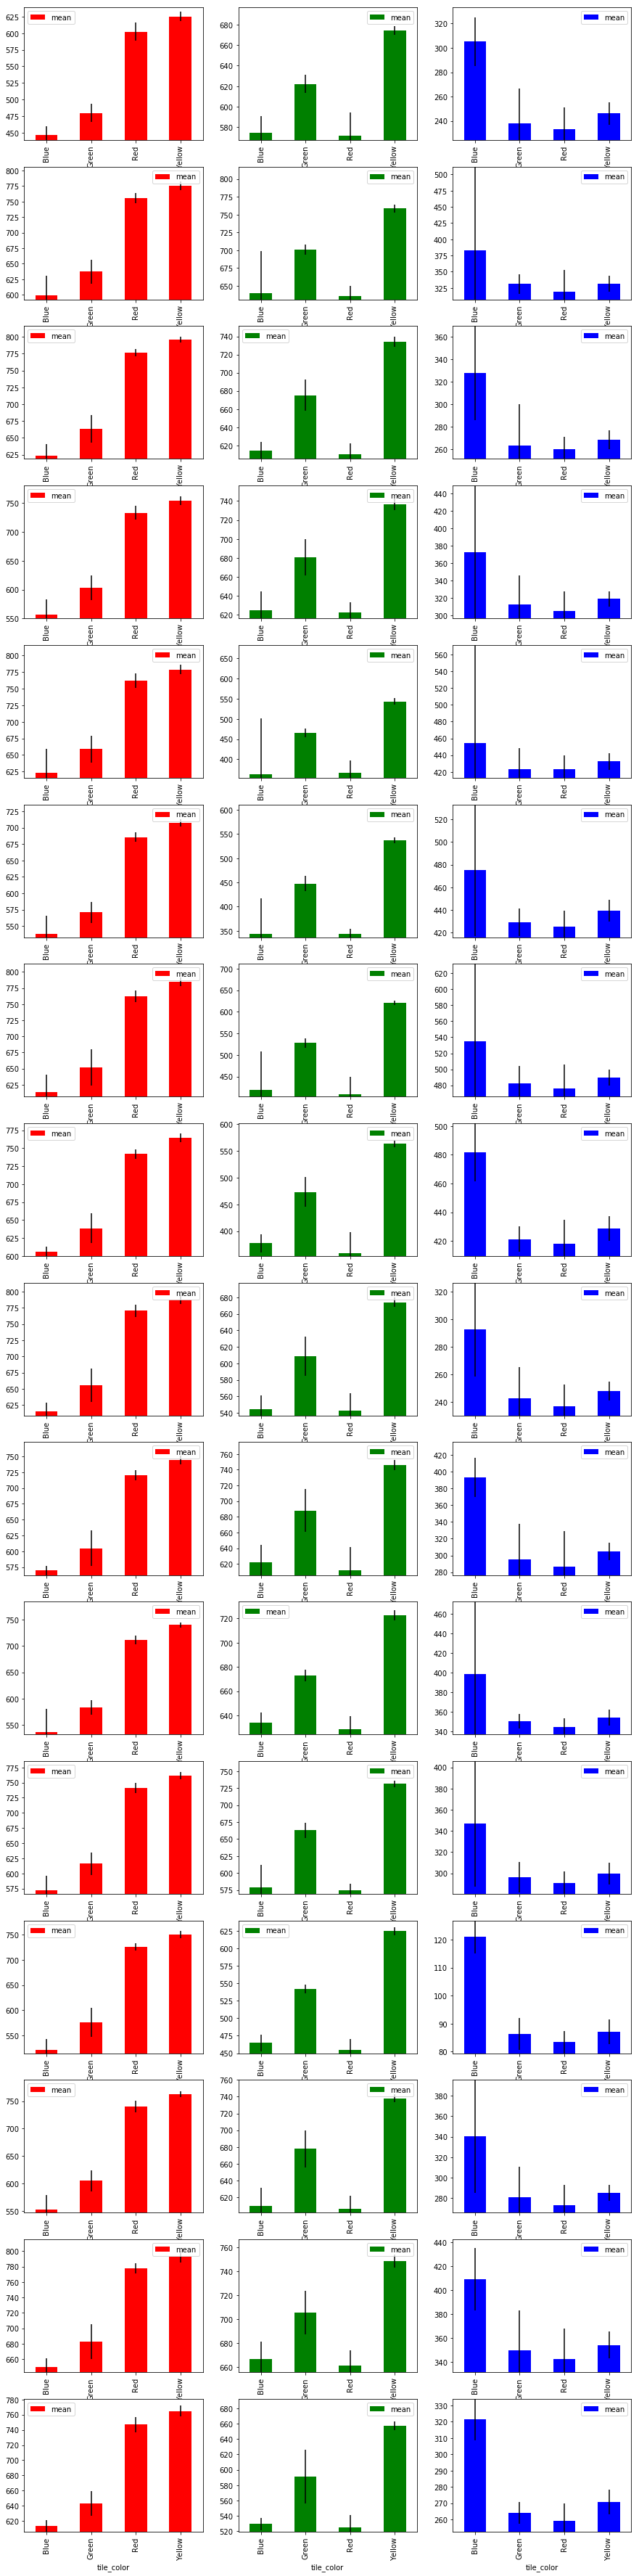

In [295]:
def error(x):
    return x.std()*5
t = df.groupby(['tile','color','tile_color'])['value'].agg(['mean',error])

fig, ax = plt.subplots(16,3,figsize=(15,4*16))
for tile in range(0,16):
    for i, color in enumerate(['red','green','blue']): 
        data = t.loc[(tile,color)]
        data.plot.bar(y='mean',yerr='error',color=color,ax=ax[tile,i]) 
        ax[tile,i].set_ylim(data['mean'].min()-data['error'].min(),data['mean'].max()+data['error'].max())

In [ ]:
red,yellow | green red
red,green | red green
red,blue | red blue
yellow,green| red green
yellow,blue| red, blue
green,blue| blue, green

In [ ]:
# first 16 are ldrs with rgb led off
# 2nd 16 are ldrs with rgb=red
# 3rd 16 are ldrs with rgb=green
# final 16 are ldrs with rbg=blue  

In [66]:
off = a.loc[:,0:15].copy()
red = a.loc[:,16:31].copy()
green = a.loc[:,32:47].copy()
blue = a.loc[:,48:63].copy()


In [241]:
df = pd.read_csv("data/data_201803301945.csv",header=None, names=["tile","color","value","config"])#.dropna(how='any')
df['tile'] = df['tile'].astype('int')
df['color'] = df['color'].map({7:'blue',8:'green',9:'red',0:'off'})
df['tile_row'] = df['tile']//4
def lookup_color(row):
    return row['config'].split("|")[row['tile_row']]
df['tile_color'] = df.apply(lookup_color,axis=1)
df.drop(labels='config',inplace=True,axis=1)

TypeError: ('list indices must be integers, not float', u'occurred at index 0')

In [235]:
df.head()

,tile,color,value,tile_row,tile_color
0,0,blue,238,0,Red
1,1,blue,330,0,Red
2,2,blue,253,0,Red
3,3,blue,314,0,Red
4,4,blue,423,1,Green


In [238]:
df.groupby(['tile','tile_color','color'])['value'].agg(['mean','std'])

mean       std
tile tile_color color                      
0    Blue       blue   304.000000       NaN
                green  575.000000       NaN
                off      0.000000  0.000000
                red    447.000000       NaN
     Green      blue   246.000000  0.000000
                off      0.000000  0.000000
                red    483.000000       NaN
     Red        blue   238.000000  0.000000
                green  573.000000       NaN
                off      0.000000       NaN
     Yellow     blue   238.500000  0.707107
                green  568.000000       NaN
                off      0.000000  0.000000
                red    602.000000       NaN
1    Blue       blue   403.000000       NaN
                green  652.000000       NaN
                off      0.000000  0.000000
                red    607.000000       NaN
     Green      blue   321.000000  0.000000
                off      1.000000  0.000000
                red    646.000000       NaN
     Red        blue   329.666667  0.577350
                green  637.000000       NaN
                off      0.000000       NaN
     Yellow     blue   315.000000  0.000000
                green  643.000000       NaN
                off      0.500000  0.707107
                red    759.000000       NaN
2    Blue       blue   346.000000       NaN
                green  622.000000       NaN
...                           ...       ...
13   Green      blue   277.000000       NaN
                off      1.000000       NaN
                red    609.000000       NaN
     Red        blue   292.000000       NaN
                green  740.000000       NaN
                off      2.000000       NaN
     Yellow     blue   293.000000  0.000000
                green  740.500000  0.707107
14   Blue       blue   420.000000  0.000000
                green  670.000000       NaN
                off      1.000000       NaN
     Green      blue   355.000000       NaN
                off      1.000000       NaN
                red    678.000000       NaN
     Red        blue   357.000000       NaN
                green  751.000000       NaN
                off      1.000000       NaN
     Yellow     blue   358.000000  0.000000
                green  751.500000  0.707107
15   Blue       blue   336.000000  0.000000
                green  554.000000       NaN
                off      0.000000       NaN
     Green      blue   267.000000       NaN
                off      0.000000       NaN
                red    644.000000       NaN
     Red        blue   273.000000       NaN
                green  659.000000       NaN
                off      0.000000       NaN
     Yellow     blue   273.000000       NaN
                green  660.500000  0.707107

[186 rows x 2 columns]

In [187]:
# lets just look at one tile. 
red = df[df[64]=="Red|Green|Blue|Yellow"]
green = df[df[64]=="Green|Blue|Yellow|Red"]
blue = df[df[64]=="Blue|Yellow|Red|Green"]
yellow = df[df[64]=="Yellow|Red|Green|Blue"]

In [ ]:
# first 16 are ldrs with rgb led off
# 2nd 16 are ldrs with rgb=red
# 3rd 16 are ldrs with rgb=green
# final 16 are ldrs with rbg=blue 

In [194]:
pd.options.display.max_columns=64

In [195]:
yellow.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,...,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
60,0,0,0,0,4,0,0,0,0,0,1,0,0,1,1,0,626,778,798,753,762,686,762,738,656,598,591,601,499,545,646,609,...,2,0,1,8,2,0,1,1,0,2,1,0,3,3,2,240,326,255,307,419,419,477,408,240,290,333,276,106,329,396,305,Yellow|Red|Green|Blue
61,0,0,0,0,5,1,0,0,0,0,0,0,0,2,1,0,626,778,798,753,762,685,761,738,656,599,591,601,499,545,646,610,...,1,0,1,8,2,0,1,1,0,2,2,0,3,3,2,240,326,255,307,419,419,477,408,239,290,333,276,106,328,395,305,Yellow|Red|Green|Blue
62,0,0,0,0,4,0,0,0,0,0,0,0,0,1,2,0,626,778,798,754,762,686,761,738,656,599,591,601,499,545,646,610,...,2,0,1,8,1,1,1,2,0,2,1,0,3,4,2,240,326,255,307,419,419,477,408,240,290,333,276,106,328,396,305,Yellow|Red|Green|Blue
63,0,0,0,0,4,0,0,0,0,0,0,0,0,1,1,0,626,778,798,754,762,686,762,738,655,599,591,601,499,545,646,610,...,2,0,2,8,2,0,1,1,0,2,1,0,4,3,2,240,326,255,307,419,420,477,408,240,290,333,276,106,329,396,305,Yellow|Red|Green|Blue
64,0,0,0,0,4,0,0,0,0,0,0,0,0,1,1,0,626,778,798,754,761,686,762,739,655,598,591,601,499,545,646,610,...,2,0,2,7,2,0,0,1,0,2,1,0,4,3,2,240,326,255,307,419,419,477,408,239,290,333,276,106,329,395,305,Yellow|Red|Green|Blue


In [151]:
def reformat(df):
    def lookup_color(row):
        return row['tile_lookup'].split("|")[row['tile_row']]

    def restack(a,rgb):
        indx = {'off':0, 'red':16, 'green':32, 'blue':48}
        df = a.loc[:,indx[rgb]:indx[rgb]+15].copy() 
        df.columns = range(16)
        df = df.stack().reset_index()
        df.columns = ['row','tile_lookup','tile_number','value']
        df['led'] = rgb
        df['tile_row'] = df['tile_number']//4
        df['tile_color'] = df.apply(lookup_color,axis=1)
        return df[['row','led','tile_number','tile_color','value']]
    
    a = df.set_index(64,append=True)
    result = pd.concat([
        restack(a,'off'),
        restack(a,'red'),
        restack(a,'green'),
        restack(a,'blue')
    ])
    
    empty = result.query('led=="off" & value > 10')[['row','tile_number']]
    empty['empty'] = 1
    result = pd.merge(d,empty,how='left',left_on=('row','tile_number'),right_on=('row','tile_number'))
    result.loc[tmp['empty'].notnull(),'tile_color'] = np.nan
    
    
    return result.drop('empty',axis=1)

d = reformat(df)


In [176]:
mu = d.groupby(['led','tile_number','tile_color'])['value'].agg(['mean','std'])
mu['error'] = mu['std']*5
mu.head()

mean        std       error
led  tile_number tile_color                                
blue 0           Blue        298.750   2.072407   10.362036
                 Green       227.625   5.162426   25.812129
                 Red         226.325   5.210382   26.051908
                 Yellow      239.650   0.483046    2.415229
     1           Blue        378.150  24.040097  120.200486

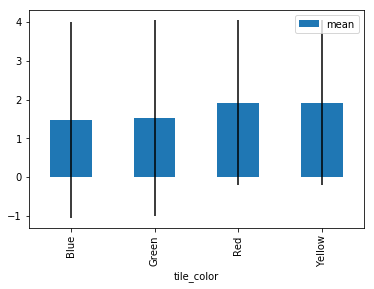

In [179]:
mu.loc[('green',1)].plot.bar(y = 'mean', yerr = 'error')

<Container object of 3 artists>

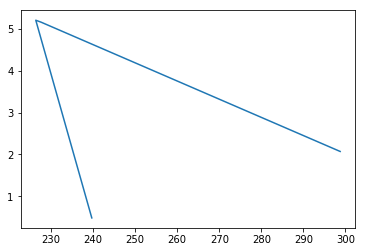

In [162]:
plt.errorbar(mu.loc[('blue',0),'mean'],mu.loc[('blue',0),'std'])

    

0    Red
1    Red
2    Red
3    Red
4    Red
Name: tile_lookup, dtype: object

In [67]:
off.columns = ["tile{}".format(i) for i in range(1,17)]
off = off.stack().reset_index()
off.columns = ['led','tile','value']
off['led'] = 'off'

In [77]:
off.head()

,led,tile,value
0,off,tile1,0
1,off,tile2,0
2,off,tile3,0
3,off,tile4,0
4,off,tile5,4


In [87]:
df.loc[2]

,led,tile,value
2,off,tile3,0
2,red,tile3,777
2,green,tile3,0
2,blue,tile3,244


In [84]:
df.query('led == "red" & tile == "tile2"')

,led,tile,value
1,red,tile2,759
17,red,tile2,759
33,red,tile2,759
49,red,tile2,759
65,red,tile2,759
81,red,tile2,758
97,red,tile2,758
113,red,tile2,758
129,red,tile2,759
145,red,tile2,759


In [ ]:
# transform it into something like:
Tile number, RGB_LED, Tile_color

In [44]:
a.iloc[0:10,16:32]

,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,608,759,777,730,664,565,650,626,616,566,536,557,748,760,791,766
1,608,759,777,731,664,566,650,626,616,565,536,557,748,760,791,766
2,607,759,777,730,664,566,650,626,616,566,536,557,749,760,791,766
3,607,759,777,731,664,565,650,626,616,565,536,557,749,760,791,766
4,608,759,777,731,664,565,650,626,616,566,536,557,749,760,791,766
5,608,758,777,731,664,565,650,626,616,565,536,557,749,760,792,766
6,607,758,777,730,664,566,650,626,616,566,536,557,749,760,791,766
7,608,758,777,731,664,566,650,626,616,566,536,557,749,760,791,766
8,608,759,777,731,664,566,650,626,616,566,536,557,749,760,791,766
9,607,759,777,730,664,566,650,626,616,566,536,557,749,760,791,766


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64b85153d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f64b3d90e50>]], dtype=object)

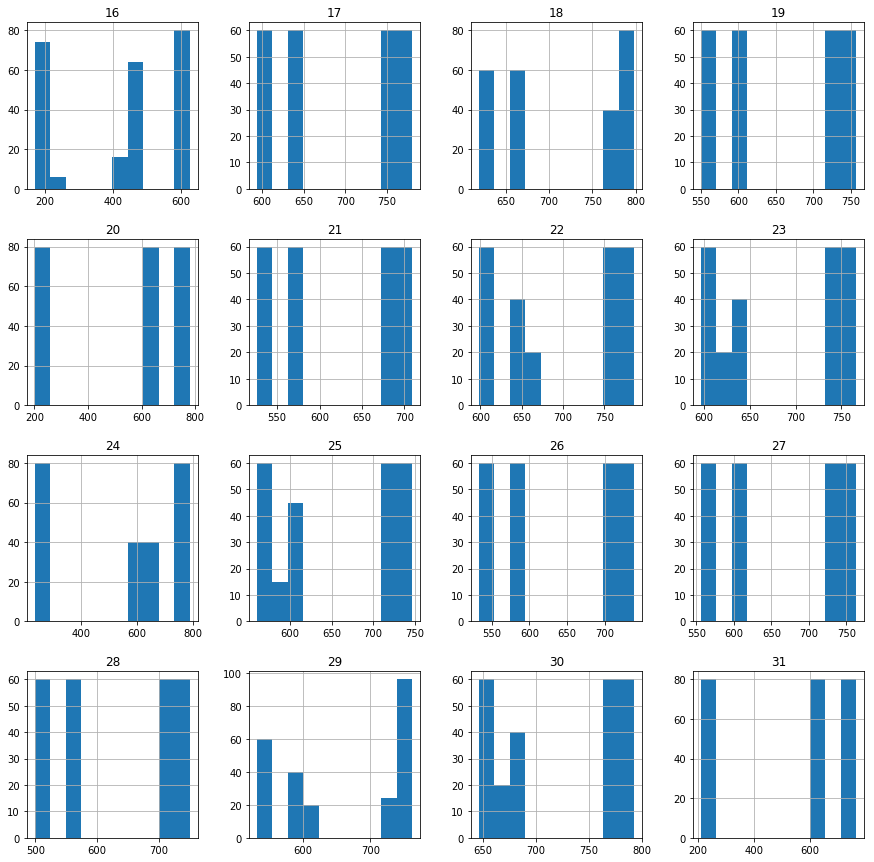

In [18]:
fig,ax = plt.subplots(1,figsize=(15,15))
df.iloc[:,16:32].hist(ax=ax)

In [17]:
df.iloc[:,16:32]

,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,608,759,777,730,664,565,650,626,616,566,536,557,748,760,791,766
1,608,759,777,731,664,566,650,626,616,565,536,557,748,760,791,766
2,607,759,777,730,664,566,650,626,616,566,536,557,749,760,791,766
3,607,759,777,731,664,565,650,626,616,565,536,557,749,760,791,766
4,608,759,777,731,664,565,650,626,616,566,536,557,749,760,791,766
5,608,758,777,731,664,565,650,626,616,565,536,557,749,760,792,766
6,607,758,777,730,664,566,650,626,616,566,536,557,749,760,791,766
7,608,758,777,731,664,566,650,626,616,566,536,557,749,760,791,766
8,608,759,777,731,664,566,650,626,616,566,536,557,749,760,791,766
9,607,759,777,730,664,566,650,626,616,566,536,557,749,760,791,766


/home/finn/miniconda3/envs/latestp2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


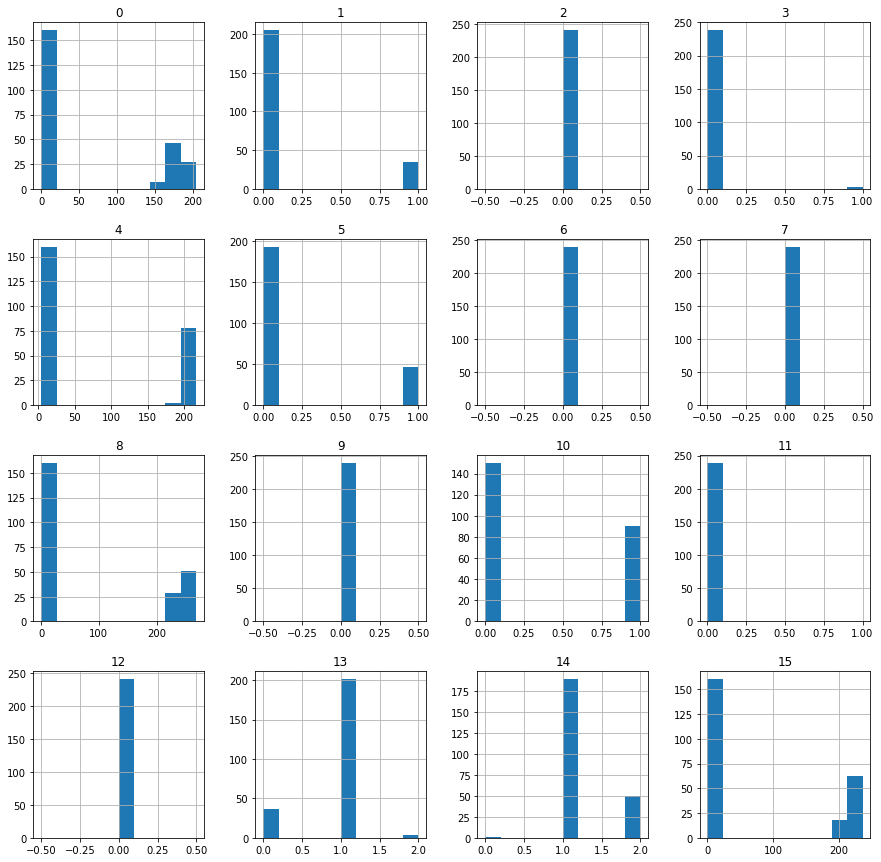

In [16]:
fig,ax = plt.subplots(1,figsize=(15,15))
plot = df.iloc[:,0:16].hist(ax=ax) # if its greater than 